<a href="https://colab.research.google.com/github/harnalashok/deeplearning-sequences/blob/main/forecastingTimeSeries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:
#Last amended: 4th March, 2021
#Myfolder: https://github.com/harnalashok/deeplearning-sequences
# Ref: Page 503, Book: Aurelien Geron
#
#Objectives:
#           i) Using SimpleRNN
#          ii) Forecasting time series

# Experiments with SimpleRNN

## Forecasting single step ahead

In [25]:
# 1.0 Call libraries
import numpy as np
import matplotlib.pyplot as plt
from  tensorflow import keras

In [3]:
# 1.1
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### Data Generation

#### Experiments

In [4]:
# 1.2 Some constants
n_steps = 50
batch_size = 4

In [ ]:
# 1.3 Get n_steps points on 'time' axis
time = np.linspace(0,1,n_steps)
time

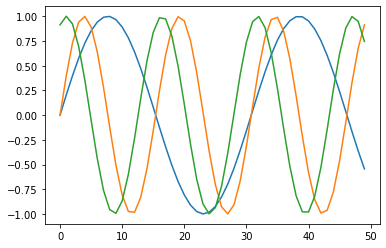

In [6]:
# 2.0 Let us plot a simple sine wave
fig = plt.figure()
_= plt.plot(np.sin(time*10))
_= plt.plot(np.sin(time*10 * 2))        # Freq double of above
_= plt.plot(np.sin(time*10 * 2 + 20))   # Double freq, but displaced by 20 units
#_= plt.plot(np.sin(time*10 * 4))       # Four times of initial freq
plt.show()

In [7]:
# 2.1 Instantiate a random number generator
rng = np.random.default_rng()

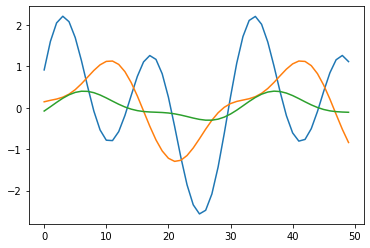

In [8]:
# 2.2 Just for fun, adding all above and plotting
_= plt.plot(np.sin(time*10) + np.sin(time*10 * 2) + np.sin(time*10 * 2 + 20))
# 2.2.1 Bring some uncertainity to amplitude
_= plt.plot(rng.random() * np.sin(time*10) + rng.random() * np.sin(time*10 * 2+ 10) + rng.random() * np.sin(time*10 * 2 + 20))
# 2.2.2 Bring some uncertainity to amplitude & offsets
_= plt.plot(rng.random() * np.sin(time*10) + rng.random() * np.sin(time*10 * 2+ 10 * rng.random()) + rng.random() * np.sin(time*10 * 2 + 20 * rng.random()))

In [ ]:
# 3.1 Generate 4 sets of 3 X 1 random numbers
#      Assign each set to four variables
freq1, freq2, offsets1, offsets2 = rng.random(size=(4,3,1))
print("\n-------\n")
freq1
print("\n-------\n")
freq2
print("\n-------\n")
offsets1
print("\n-------\n")
offsets2

In [ ]:
# 3.2 Get three sets of offsets; 50 numbers each   
theta1 = time - offsets1  # time gets subtracted 3 times
                          #  by each one of the offsets, in turn 
theta1  
theta1.shape   # (3, 50)

In [11]:
# 3.3 We create three time series each with 
#      a different frequency
#       For every one of the 3, thetas, 

f1 = freq1 * 10 + 10               # freq1 has three diff values

# 3.3.1
series = 0.5 * np.sin(theta1 * f1) # We have three time series
series.shape

(3, 50)

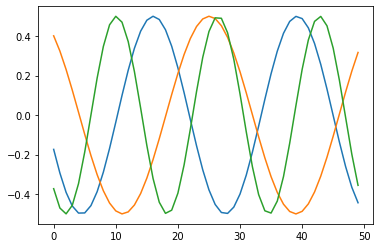

In [12]:
# 3.3.2 Plot the above three series
fig = plt.figure()
_= plt.plot(series[0])
_= plt.plot(series[1])
_= plt.plot(series[2])
plt.show()

In [13]:
# 3.3 Modify the above series.
#     On the earlier time series
#     superimpose another small 
#     sine-wave fluctuations

theta2 = time - offsets2

# 3.4
f2 = freq2 * 20 + 20
series += 0.2 * np.sin(theta2 * f2) # We have three time series
                                    #  Each getting superimposed
                                    #   on earlier
series.shape

(3, 50)

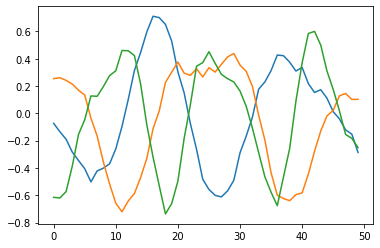

In [16]:
# 4.0 Plot the generated three series
fig = plt.figure()
_= plt.plot(series[0])
_= plt.plot(series[1])
_= plt.plot(series[2])
plt.show()

In [17]:
# 4.1 Add some noise here
series += 0.1 * ((rng.random(size = (3,50))) - 0.5)

[]

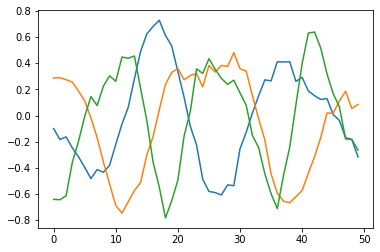

In [18]:
# 4.2 Plot the final series
fig = plt.figure()
_= plt.plot(series[0])
_= plt.plot(series[1])
_= plt.plot(series[2])
plt.plot()

In [19]:
# 4.3 Finally add one axis to series
#     as may be needed by keras NN

series = series[...,np.newaxis].astype(np.float32)
series.shape

(3, 50, 1)

#### Data Generation function

In [20]:
# 5.0 Put all above in one function
#     Write a function to generate time-series:

def generate_time_series(batch_size,n_steps):
  # 5.1
  time = np.linspace(0,1,n_steps)
  # 5.2
  freq1,freq2,offsets1,offsets2 = rng.random(size = (4,batch_size,1))
  # 5.3
  series =  0.5 * np.sin((time - offsets1) * (freq1 * 10 +10))
  # 5.4
  series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 +20))
  # 5.5
  series += 0.1 * (rng.random(size = (batch_size, n_steps)) - 0.5 ) # Noise vary around 0.5
  # 5.6
  return series[...,np.newaxis].astype(np.float32)


In [21]:
# 6.0 Generate a sample of three time-series
#     each with 50 steps(or columns!)
gt= generate_time_series(3,50)
gt.shape

(3, 50, 1)

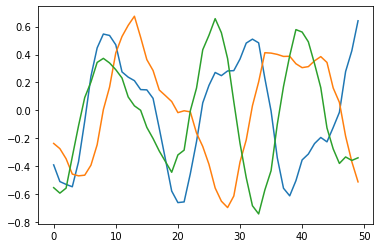

In [22]:
# 6.1 Plot the three generated series
fig = plt.figure()
_= plt.plot(gt[0])
_= plt.plot(gt[1])
_= plt.plot(gt[2])
plt.show()

In [ ]:
## 7.0 Problem:
#      Given a time series, predict the next value in time. 
#      That is we forecast only for one time-step

In [23]:
# 7.1
# Generate now train and test data
# Let batch_size be 10000
# That is we get a batch of 10000 series 
# with each having n_steps values (or columns)
# n_steps + 1; the last 1 is for our y_train,y_valid,y_test  

n_steps = 50
series = generate_time_series(10000, n_steps +1 )
series.shape                                                    

(10000, 51, 1)

#### Train/test/validation data

In [24]:
# 7.1 First 7000 series are train data

X_train, y_train = series[:7000, :n_steps], series[:7000,-1]

# 7.2 Next 2000 series are validation data
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000,-1]

# 7.3 Next 1000 series are test data
X_test, y_test = series[9000:, :n_steps], series[9000:,-1]

In [ ]:
# 7.2 Naive forecasting
#     Value to be predicted is same as the
#     last value in our validation data ie X_valid[:,-1]

In [28]:
# 7.3 What is MSE if we make Naive forecasting
#     This error will be our benchmark

# 7.3.1 What happended yesterday
#       is our prediction for future
#       So what happended at n_step
#       is prediction for n_step+1

y_pred = X_valid[:,-1]
print("\n----y_pred-----\n")

# 7.3.2
print("\n----y_pred shape-----\n")
y_pred.shape  # (2000,1)

# 7.3.3
y_pred[:4]   # for each one of Ist four series

# 7.3.4 Calculate MSE
print("\n----losses-----\n")
np.mean(keras.losses.mean_squared_error(y_valid,y_pred))

# 7.3.5 Same as:
print("\n----losses-----\n")
np.sum((y_valid - y_pred) ** 2)/2000


----y_pred-----


----y_pred shape-----



(2000, 1)

array([[ 0.36025193],
       [ 0.14951588],
       [ 0.27241346],
       [-0.40844718]], dtype=float32)


----losses-----



0.020451115


----losses-----



0.020451114654541015

### Sequential Dense Model
Let us treat this data as a tabular data and develop first a sequential model. The total data is (10000,50)

In [ ]:
# 8.0 Delete earlier models if they exist
if model:
  del model

if model1:
  del model1

if model2:
  del model2

if model3:
  del model3

In [30]:
# 8.1
model = keras.models.Sequential([
                                 # Shape of input should be tabular ie: (7000,50)
                                 # And not (7000,50,1)
                                 keras.layers.Flatten(input_shape = (50,1)),
                                 keras.layers.Dense(1)
                                ])
# 8.2
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 51
Trainable params: 51
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 8.3 Compile and fit the model
model.compile(
              loss = 'mean_squared_error',
              metrics='mean_squared_error'
              )

# 8.2 So what is MSE for validation data
model.fit(
          X_train,
          y_train,
          epochs = 20,
          validation_data= (X_valid,y_valid)
          )

### Sequential model for SimpleRNN
Let us now perform the modeling using a SimpleRNN of keras having just one neuron

##### [A Visual Guide to Recurrent Layers in Keras](https://amitness.com/2020/04/recurrent-layers-keras/)

Each sentence has three words. Each word is a vector in two-dimensions. We design our RNN model as:

---

model = Sequential()<br>
model.add(SimpleRNN(4, input_shape=(3, 2)))<br>

---


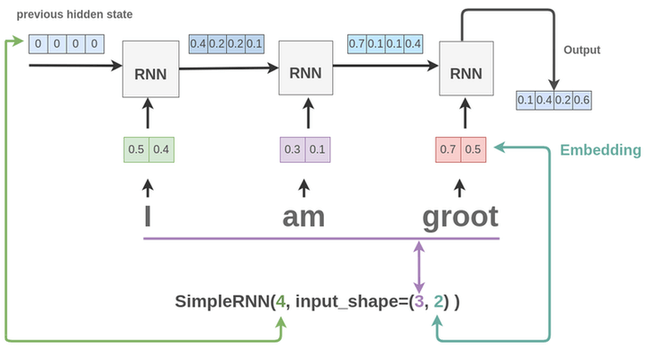







In [32]:
# 9.0 To understand what our data looks like
#      Here is a small sample of it
#       We produce 1-batches of 4 pts

generate_time_series(1, 4 )

array([[[-0.292769  ],
        [-0.39006314],
        [ 0.2378277 ],
        [ 0.6115954 ]]], dtype=float32)

In [33]:
# 9.1 Here is our model:
model1 = keras.models.Sequential(
                                  [
                                    keras.layers.SimpleRNN(
                                                           1,                   # Output neuron
                                                           input_shape = [50,1] # Input neuron is also 1
                                                                                # NN will be unrolled 50 times
                                                           )
                                  ]
                                 )

In [ ]:
# 9.2 Compile and train the model
model1.compile(loss = 'mean_squared_error', metrics='mean_squared_error')

# 9.2.1
model1.fit(
           X_train,
           y_train,
           epochs = 20,
           validation_data= (X_valid,y_valid)
           )


### Deep RNN
Having stacks of RNN

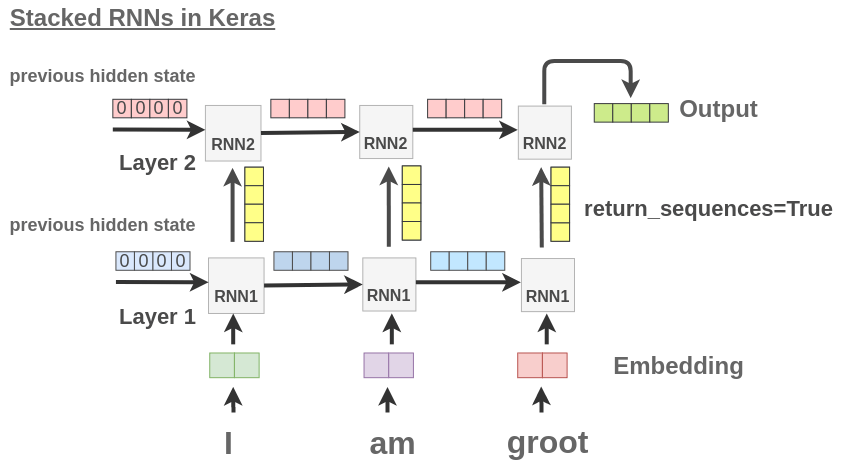



In [35]:
# 10.0 Our model
model2 = keras.models.Sequential(
                                  [
                                   keras.layers.SimpleRNN(
                                                           20,  # No of output neurons
                                                           return_sequences=True, # Each neuron returns output
                                                           input_shape = [50,1]
                                                          ),
                                   
                                   keras.layers.SimpleRNN(20, return_sequences=True),
                                   keras.layers.SimpleRNN(1)
                                  ]
                                 )


In [ ]:
# 10.1 Compile and train the model
model2.compile(loss = 'mean_squared_error', metrics='mean_squared_error')

# 10.2
model2.fit(
           X_train,
           y_train,
           epochs = 20,
           validation_data= (X_valid,y_valid)
           )


## Forecasting multiple steps ahead
Let us forecast tem steps ahead

#### Data generation

In [47]:
# 11.0 Generate series and get data
series = generate_time_series(10000, n_steps+10)
# 11.1
X_train,y_train = series[:7000,:n_steps], series[:7000,-10: , 0]
# 11.2
X_valid,y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
# 11.3
X_test, y_test = series[9000:, :n_steps], series[9000:,-10:,0]

In [48]:
# 11.4 Here are shapes of data
X_train.shape   # (7000, 50, 1)
y_train.shape   # (7000, 10)
X_test.shape    # (1000, 50, 1)
y_test.shape    # (1000, 10)
X_valid.shape   # (2000, 50, 1)
y_valid.shape   # (2000, 10)

(7000, 50, 1)

(7000, 10)

(1000, 50, 1)

(1000, 10)

(2000, 50, 1)

(2000, 10)

#### SimpleRNN stacked model

In [49]:
# 12: We build our model and our last layer is Dense
model3 = keras.models.Sequential(
                                 [
                                  keras.layers.SimpleRNN(
                                                         20,   # Output neurons
                                                         return_sequences=True,
                                                         input_shape = [10,1]
                                                         ),
                                  keras.layers.SimpleRNN(20),  # return sequences is False
                                                               #  Each one of the 10 unrolled NNs, 
                                                               #    has 20 neurons at the output 
                                  keras.layers.Dense(10)
                                 ]
                               )

In [ ]:
# 10.1 Compile and train the model
model3.compile(loss = 'mean_squared_error', metrics='mean_squared_error')

# 10.2
model3.fit(
           X_train,
           y_train,
           epochs = 20,
           validation_data= (X_valid,y_valid)
           )


##### Data to make prediction

In [89]:
# 11.0 Generate one time series to make prediction
series = generate_time_series(1,n_steps+ 10)
# 11.1
X_new, y_new = series[:, :n_steps], series[:, n_steps:]
# 11.2 make prediction
y_pred = model3.predict(X_new)

In [90]:
# 12. Data shapes
X_new.shape     # (1, 50, 1) : For Ist series (50,1) pts
y_new.shape     # (1, 10, 1) : For Ist series (10,1) pts
y_pred.shape    # (1, 10)    : Prediction of Ist series  

(1, 50, 1)

(1, 10, 1)

(1, 10)

In [91]:
# 12.1 Reshape all data to 1D to facilitate plotting
X_new = X_new.reshape(50,)
y_pred = y_pred.reshape(10,)
y_new = y_new.reshape(10,)

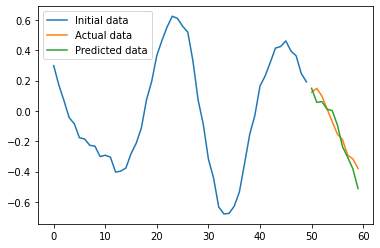

In [93]:
# 12.2 plot now
fig = plt.figure()
# AA
_= plt.plot(np.arange(50),X_new, label = "Initial data")       # AA First 50 points
# AB
_= plt.plot(np.arange(50,60), y_new, label = "Actual data"  )  # AB Actual next 10 pts
# AC
_= plt.plot(np.arange(50,60),y_pred, label = "Predicted data") # AC Prediction(s) for 'AB' based on AA
_ = plt.legend()
plt.show()

In [ ]:
############# I am done ################